# Typed State

In this example we're going to be using state-typing with instructor + Burr to generate social media posts from youtube videos.

First, let's define some pydantic models. Note you'll need the env var `OPENAI_API_KEY` set. 

In [22]:
%pip install 'burr[pydantic]' instructor openai rich


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Imports/setup

In [26]:
from typing import AsyncGenerator, Generator, Optional, Tuple, Union

import instructor
import openai
from pydantic import BaseModel, Field
from pydantic.json_schema import SkipJsonSchema
from rich.console import Console
from youtube_transcript_api import YouTubeTranscriptApi

from burr.core import Application, ApplicationBuilder, action
from burr.core.action import (
    AsyncStreamingResultContainer,
    StreamingResultContainer,
    streaming_action,
)
from burr.integrations.pydantic import PydanticTypingSystem
import json
import time
from rich import print_json
from IPython.display import clear_output

# Constructs

Let's define some pydantic models to use -- these will help shape our application

In [11]:
class Concept(BaseModel):
    term: str = Field(description="A key term or concept mentioned.")
    definition: str = Field(description="A brief definition or explanation of the term.")
    timestamp: float = Field(description="Timestamp when the concept is explained.")

class SocialMediaPost(BaseModel):
    """A social media post about a YouTube video generated its transcript"""

    topic: str = Field(description="Main topic discussed.")
    hook: str = Field(
        description="Statement to grab the attention of the reader and announce the topic."
    )
    body: str = Field(
        description="The body of the social media post. It should be informative and make the reader curious about viewing the video."
    )
    concepts: list[Concept] = Field(
        description="Important concepts about Hamilton or Burr mentioned in this post -- please have at least 1",
        min_items=0,
        max_items=3,
        validate_default=False,
    )
    key_takeaways: list[str] = Field(
        description="A list of informative key takeways for the reader -- please have at least 1",
        min_items=0,
        max_items=4,
        validate_default=False,
    )
    youtube_url: SkipJsonSchema[Union[str, None]] = None

# State Type

Using those, we'll define a core pydantic model that sets up the central schema for our application. Note these are optional, they won't be set when our application starts!

In [12]:
class ApplicationState(BaseModel):
    # Make these have defaults as they are only set in actions
    transcript: Optional[str] = Field(
        description="The full transcript of the YouTube video.", default=None
    )
    post: Optional[SocialMediaPost] = Field(
        description="The generated social media post.", default=None
    )

# Write an action to transcribe a youtube URL

Note we take in a youtube URL + the state in the format we want, and write to `transcript`. We actually read nothing, as the transcript is an input.
Different than normal Burr, we actually mutate the model we send in (this allows us to leverage pydantic validation).

In [16]:
@action.pydantic(reads=[], writes=["transcript"])
def get_youtube_transcript(state: ApplicationState, youtube_url: str) -> ApplicationState:
    """Get the official YouTube transcript for a video given its URL"""
    _, _, video_id = youtube_url.partition("?v=")

    transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=["en"])
    state.transcript = " ".join([f"ts={entry['start']} - {entry['text']}" for entry in transcript])
    return state

# Write an action to stream back pydantic models

We specify the state input type, state output type, and the stream type, streaming it all back using [instructors streaming capability](https://python.useinstructor.com/concepts/partial/)

In [18]:
@streaming_action.pydantic(
    reads=["transcript"],
    writes=["post"],
    state_input_type=ApplicationState,
    state_output_type=ApplicationState,
    stream_type=SocialMediaPost,
)
def generate_post(
    state: ApplicationState, llm_client
) -> Generator[Tuple[SocialMediaPost, Optional[ApplicationState]], None, None]:

    transcript = state.transcript
    response = llm_client.chat.completions.create_partial(
        model="gpt-4o-mini",
        response_model=SocialMediaPost,
        messages=[
            {
                "role": "system",
                "content": "Analyze the given YouTube transcript and generate a compelling social media post.",
            },
            {"role": "user", "content": transcript},
        ],
        stream=True,
    )
    final_post: SocialMediaPost = None  # type: ignore
    for post in response:
        final_post = post
        yield post, None

    yield final_post, state

# Wire together in an application

We  specify the application to have type `ApplicationState` as the state, and pass it an initial value

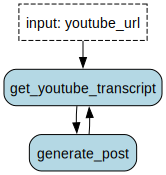

In [24]:
llm_client = instructor.from_openai(openai.OpenAI())
app = (
    ApplicationBuilder()
    .with_actions(
        get_youtube_transcript,
        generate_post.bind(llm_client=llm_client),
    )
    .with_transitions(
        ("get_youtube_transcript", "generate_post"),
        ("generate_post", "get_youtube_transcript"),
    )
    .with_entrypoint("get_youtube_transcript")
    .with_typing(PydanticTypingSystem(ApplicationState))
    .with_state(ApplicationState())
    .with_tracker(project="youtube-post")
    .build()
)
# in case we want to access the state
assert isinstance(app.state.data, ApplicationState)
app

# Run it!

Now we can run it!

In [32]:
_, streaming_container = app.stream_result(
    halt_after=["generate_post"],
    inputs={"youtube_url": "https://www.youtube.com/watch?v=hqutVJyd3TI"},
)
for post in streaming_container:
    assert isinstance(post, SocialMediaPost)
    clear_output(wait=True)
    obj = post.model_dump()
    json_str = json.dumps(obj, indent=2)
    print_json(json_str)

{
  "topic": "Burr Framework Overview",
  "hook": "Ever faced challenges while debugging AI applications? Here's a solution!",
  "body": "Dive into the world of agent applications with Burr! In this quick overview, we explore how Burr helps you debug failing AI calls and track state effectively. Learn to build a graph that connects actions and states, allowing you to resume your application exactly where you left off. Whether it’s fixing an error mid-run or replaying past actions, Burr's observability features enhance your development workflow. Ready to optimize your debugging process? Check out the full video to unravel the potential of Burr!",
  "concepts": [
    {
      "term": "Agent Application",
      "definition": "A system that models states and actions to create decision-making processes.",
      "timestamp": 105.479
    },
    {
      "term": "State Object",
      "definition": "An object that holds the state information for actions to read and write during execution.",
      "timestamp": 145.56
    },
    {
      "term": "Graph Representation",
      "definition": "A structural representation of actions and their interconnections in an agent system, depicted as nodes and edges.",
      "timestamp": 179.28
    }
  ],
  "key_takeaways": [
    "Burr allows near-instantaneous debugging without restarting from scratch.",
    "The framework promotes building a stateful graph structure for actions.",
    "Use local tracking to effortlessly monitor and interact with your agent's state."
  ],
  "youtube_url": null
}